In [8]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools 
import pandas as pd

# Suppress all warnings
warnings.filterwarnings("ignore")

In [9]:
# file path
file_path = 'physicians-in-canada-1971-2022.xlsx'

# Specify the range of columns and rows to read (I was getting NaN where there was no real blanks) 
columns_range = 'A:BH'
num_rows = 101698

# Read the specific range from the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='Table 1 Physician workforce', usecols=columns_range, nrows=num_rows)

# Replace NaN values in Health region column with the corresponding 'Jurisdiction' values to simplify the filtering by province
df['Health region'] = df.apply(
    lambda row: row['Jurisdiction'] if pd.isna(row['Health region']) else row['Health region'],
    axis=1
)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101697 entries, 0 to 101696
Data columns (total 60 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   Year                                                           101697 non-null  int64  
 1   Jurisdiction                                                   101697 non-null  object 
 2   Health region                                                  101697 non-null  object 
 3   Specialty                                                      101697 non-null  object 
 4   Specialty sort                                                 101697 non-null  int64  
 5   Physician-to–100,000 population ratio                          100173 non-null  float64
 6   Number of physicians                                           101697 non-null  int64  
 7   Number male                                    

In [10]:
# Define a list of jurisdictions
jurisdictions = [
    'Canada', 'Alta.', 'B.C.', 'Man.', 'N.B.', 'N.L.', 
    'N.S.', 'N.W.T.', 'Ont.', 'P.E.I.', 'Que.', 'Sask.', 'Y.T.','Nun.'
]

# Create a dictionary to store DataFrames for each jurisdiction
jurisdiction_dfs = {}

# Loop through each jurisdiction and create the DataFrame
for jurisdiction in jurisdictions:
    jurisdiction_key = jurisdiction.replace('.', '').replace(' ', '_').lower()
    jurisdiction_dfs[jurisdiction_key] = df[
        (df['Specialty sort'] == 3) &
        ((df['Jurisdiction'] == jurisdiction) & (df['Health region'] == jurisdiction))
    ]

# Print the keys in jurisdiction_dfs
print("Keys in jurisdiction_dfs:", list(jurisdiction_dfs.keys()))

Keys in jurisdiction_dfs: ['canada', 'alta', 'bc', 'man', 'nb', 'nl', 'ns', 'nwt', 'ont', 'pei', 'que', 'sask', 'yt', 'nun']


In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools

# Define a function to evaluate ARIMA model
def evaluate_arima_model(train, validation, arima_order):
    try:
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        y_pred = model_fit.get_forecast(steps=len(validation))
        y_pred_df = y_pred.conf_int(alpha=0.05)
        y_pred_df["Predictions"] = model_fit.predict(start=validation.index[0], end=validation.index[-1])
        y_pred_df.index = validation.index
        y_pred_out = y_pred_df["Predictions"]
        rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
        return rmse
    except Exception as e:
        print(f"Failed to fit ARIMA{arima_order}: {str(e)}")
        return float('inf')  # Return infinite RMSE if model fails to converge

# Create a dictionary to store the best models for each jurisdiction
best_models = {}

# Loop through each jurisdiction and prepare data for ARIMA
for jurisdiction, df in jurisdiction_dfs.items():
    try:
        # Extract 'Number of physicians' and 'Year' columns and sort by 'Year'
        jurisdiction_data = df[['Year', 'Number of physicians']].sort_values(by='Year').reset_index(drop=True)
        
        # Split data into train and validation sets
        train_size = int(len(jurisdiction_data) * 0.8)
        train, validation = jurisdiction_data['Number of physicians'][:train_size], jurisdiction_data['Number of physicians'][train_size:]
        
        # Grid search for ARIMA hyperparameters
        p_values = range(0, 3)
        d_values = range(0, 3)
        q_values = range(0, 3)

        best_score, best_cfg = float("inf"), None

        for p, d, q in itertools.product(p_values, d_values, q_values):
            order = (p, d, q)
            try:
                rmse = evaluate_arima_model(train, validation, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
            except Exception as e:
                print(f"Issue with ARIMA{order} for {jurisdiction}: {str(e)}")
                continue
        
        # Store and print the best model result for each jurisdiction
        best_models[jurisdiction] = (best_cfg, best_score)
        print(f'Best ARIMA model for {jurisdiction}: ARIMA{best_cfg} RMSE={best_score}')
        
    except Exception as e:
        print(f"Error processing jurisdiction {jurisdiction}: {str(e)}")
        continue

Best ARIMA model for canada: ARIMA(1, 2, 1) RMSE=532.2772364877885
Best ARIMA model for alta: ARIMA(2, 2, 2) RMSE=280.9097975482264
Best ARIMA model for bc: ARIMA(2, 2, 0) RMSE=532.2616847112556
Best ARIMA model for man: ARIMA(2, 2, 2) RMSE=36.782312015979485
Best ARIMA model for nb: ARIMA(1, 2, 0) RMSE=27.919699027828877
Best ARIMA model for nl: ARIMA(1, 2, 1) RMSE=24.063562944225193
Best ARIMA model for ns: ARIMA(2, 2, 2) RMSE=37.63379879865523
Best ARIMA model for nwt: ARIMA(0, 0, 2) RMSE=6.2198140350867215
Best ARIMA model for ont: ARIMA(1, 2, 2) RMSE=621.45062287329
Best ARIMA model for pei: ARIMA(0, 2, 2) RMSE=13.884844989677397
Best ARIMA model for que: ARIMA(1, 2, 0) RMSE=351.8651314240781
Best ARIMA model for sask: ARIMA(0, 2, 1) RMSE=73.75198732514221
Best ARIMA model for yt: ARIMA(2, 2, 1) RMSE=2.8500608228991284
Best ARIMA model for nun: ARIMA(1, 0, 2) RMSE=9.738591823198291


Best ARIMA model for canada: ARIMA(1, 2, 1) RMSE=532.2772364877885


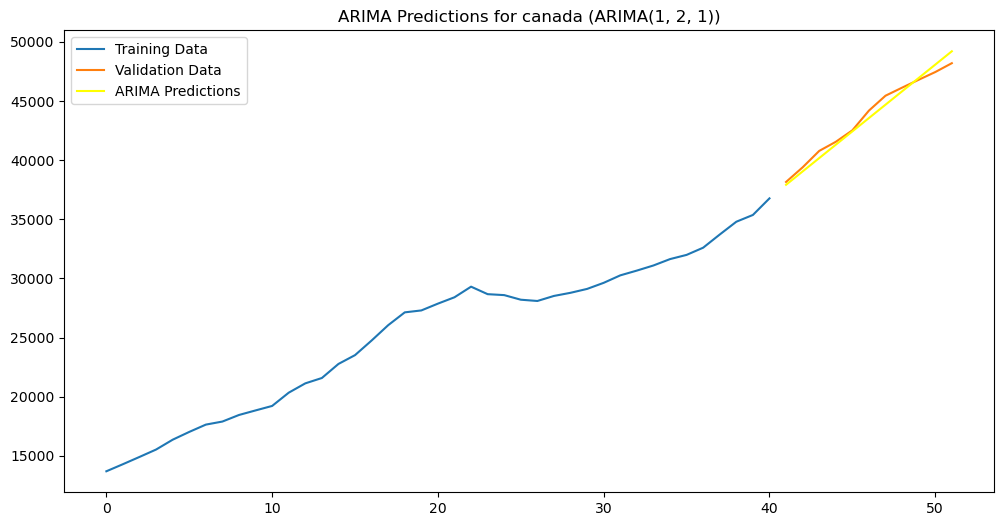

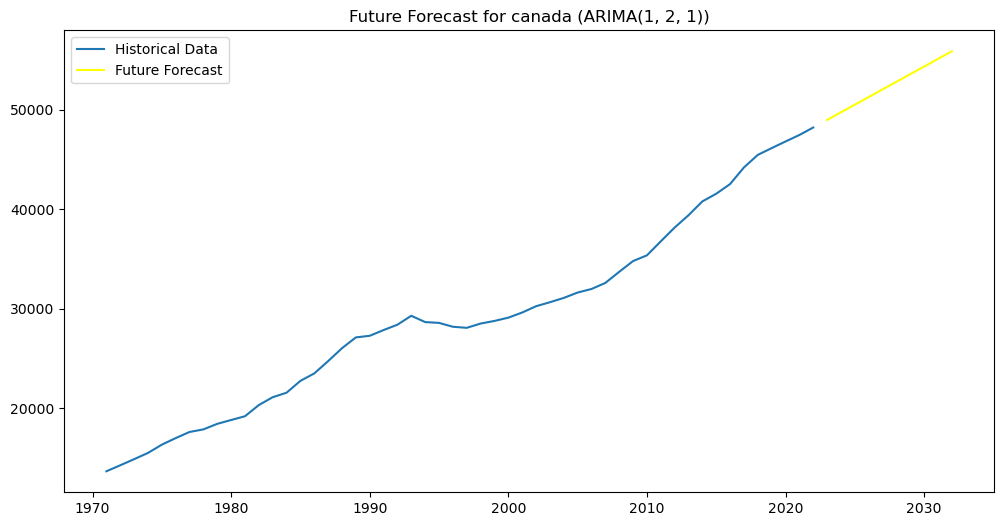

Best ARIMA model for alta: ARIMA(2, 2, 2) RMSE=280.9097975482264


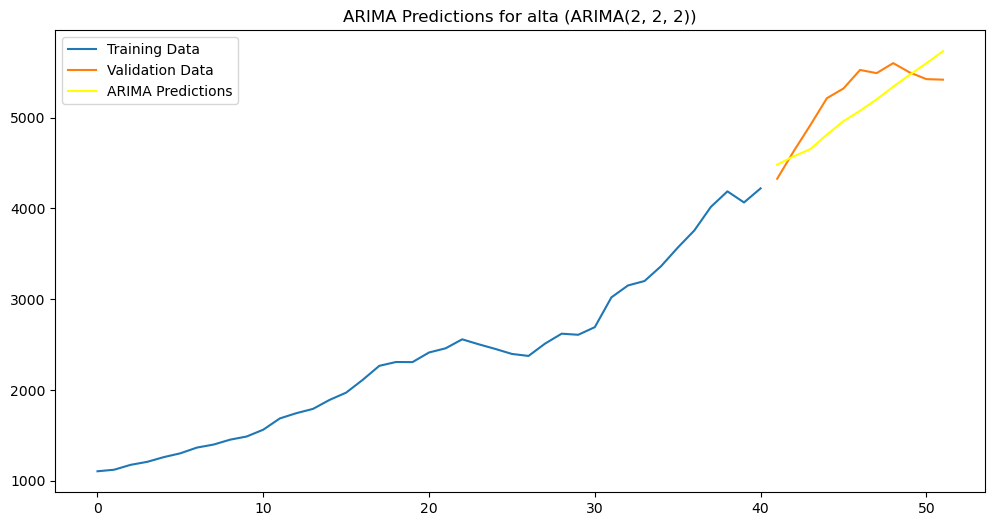

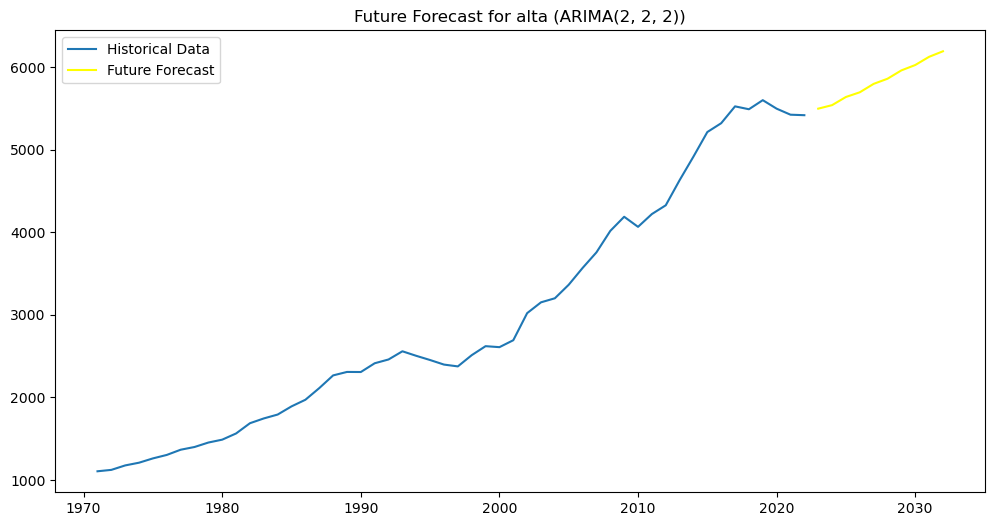

Best ARIMA model for bc: ARIMA(2, 2, 0) RMSE=532.2616847112556


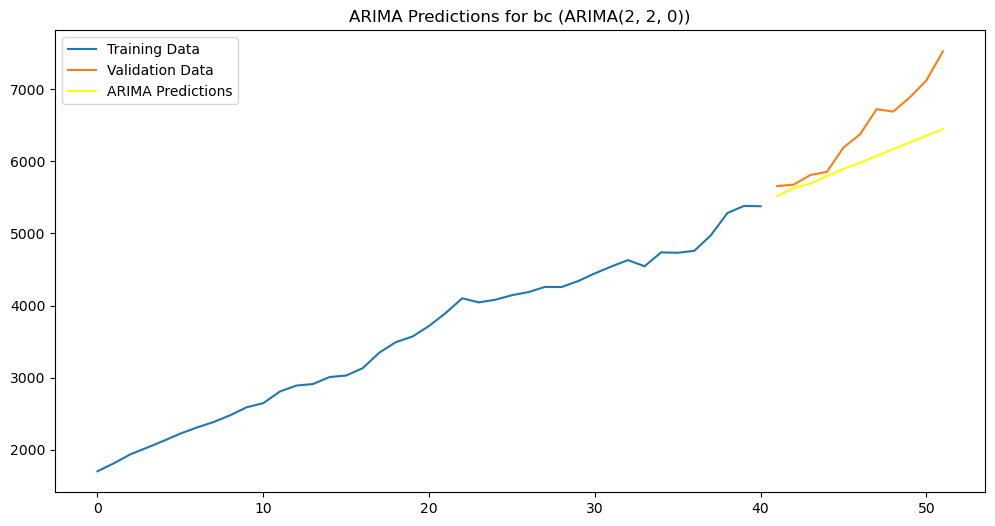

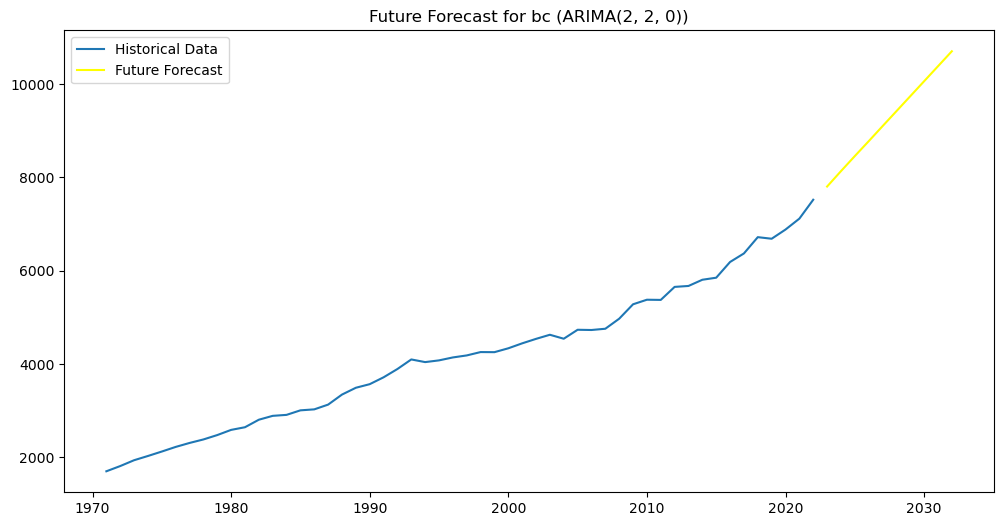

Best ARIMA model for man: ARIMA(2, 2, 2) RMSE=36.782312015979485


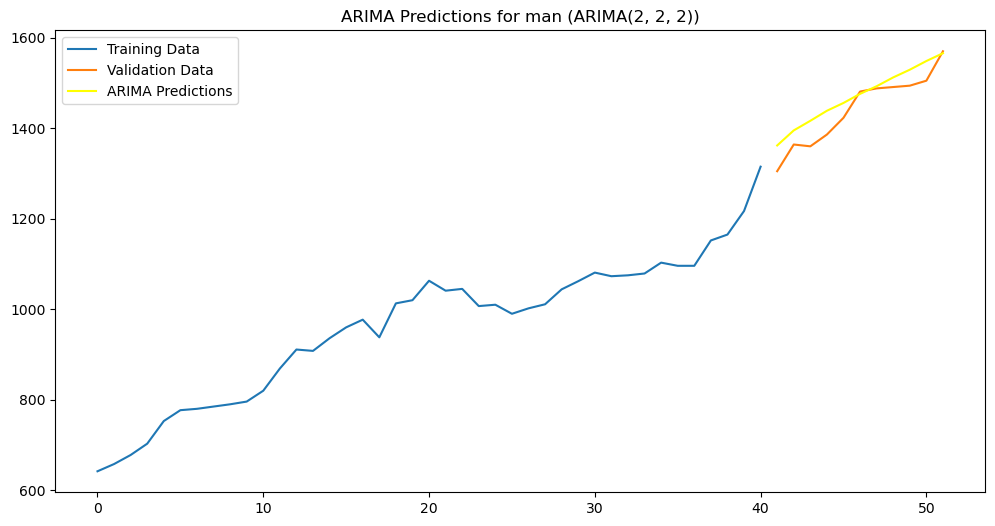

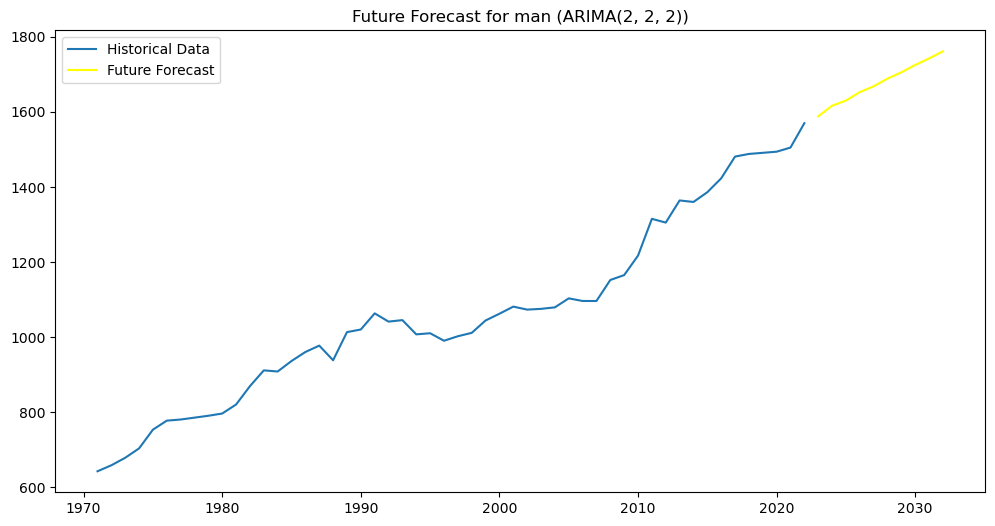

Best ARIMA model for nb: ARIMA(1, 2, 0) RMSE=27.919699027828877


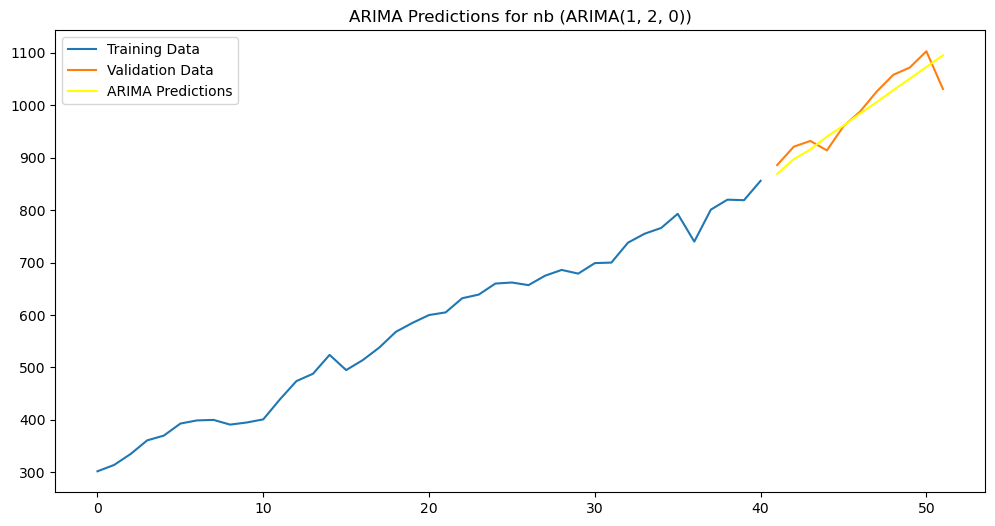

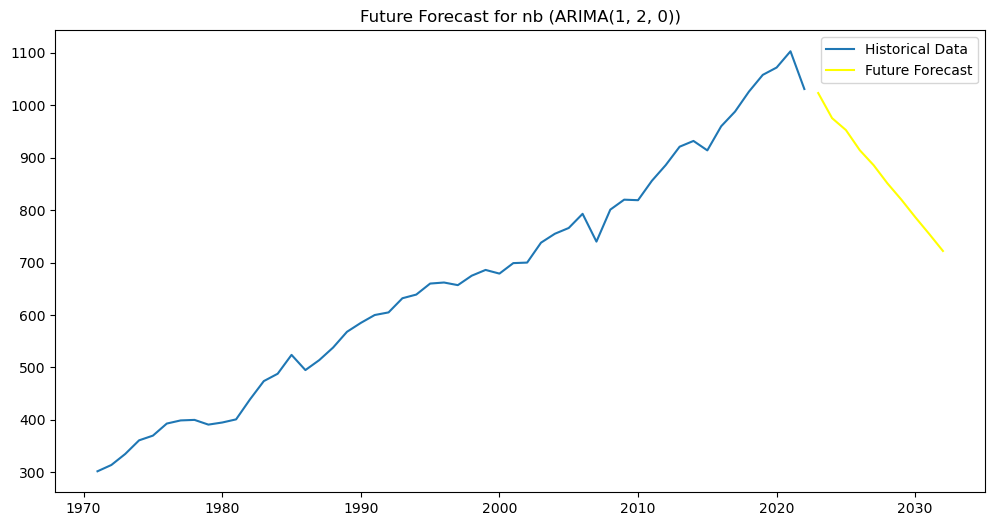

Best ARIMA model for nl: ARIMA(1, 2, 1) RMSE=24.063562944225193


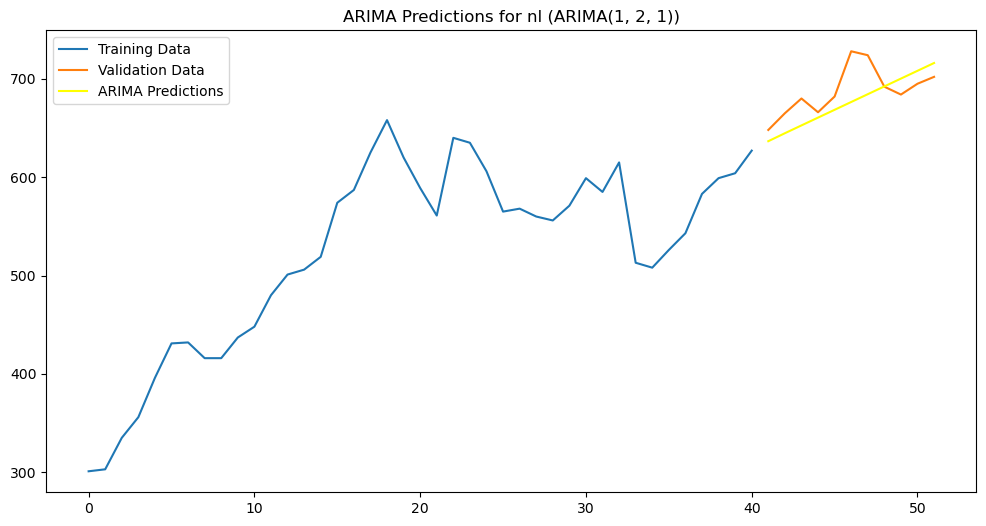

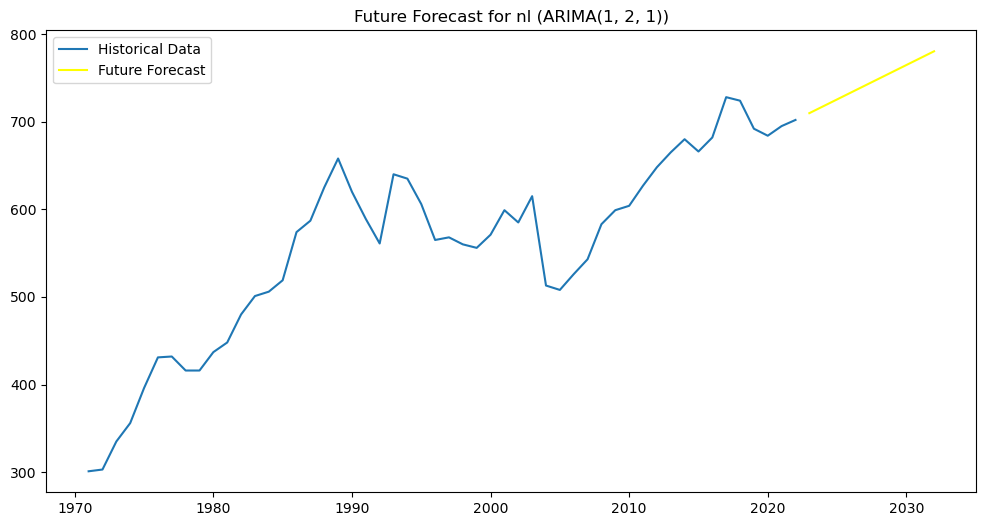

Best ARIMA model for ns: ARIMA(2, 2, 2) RMSE=37.63379879865523


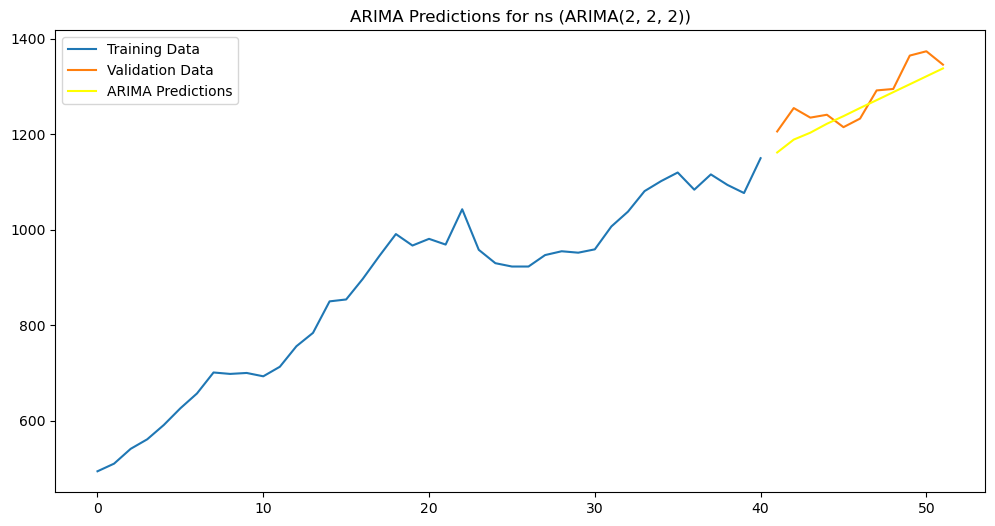

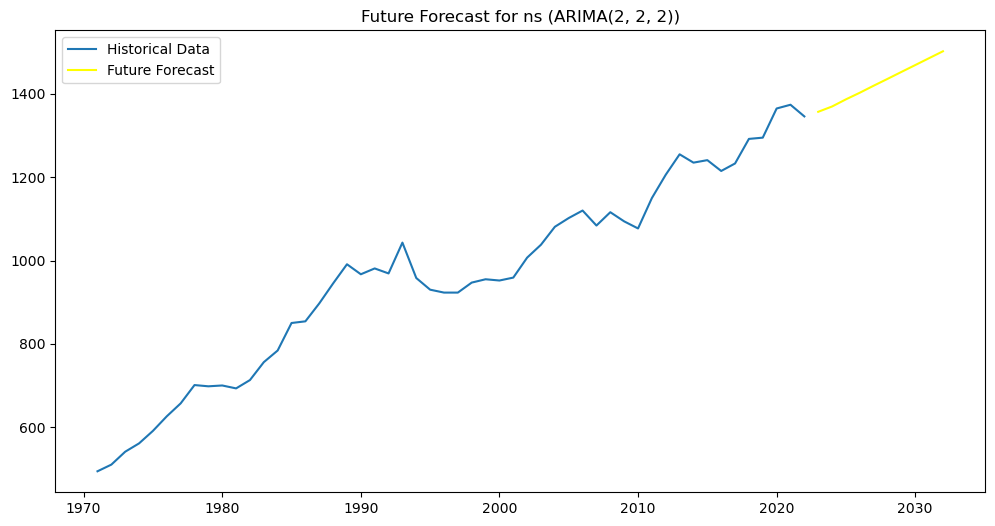

Best ARIMA model for nwt: ARIMA(0, 0, 2) RMSE=6.2198140350867215


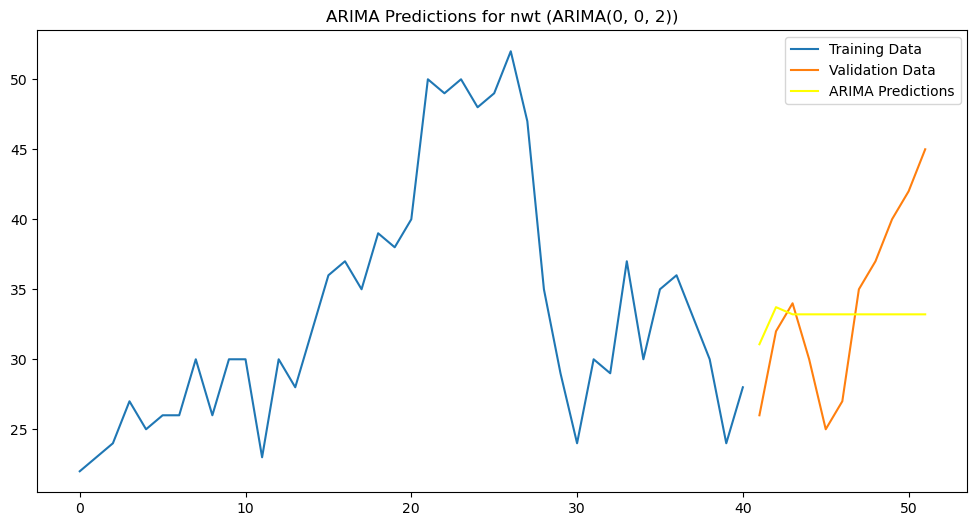

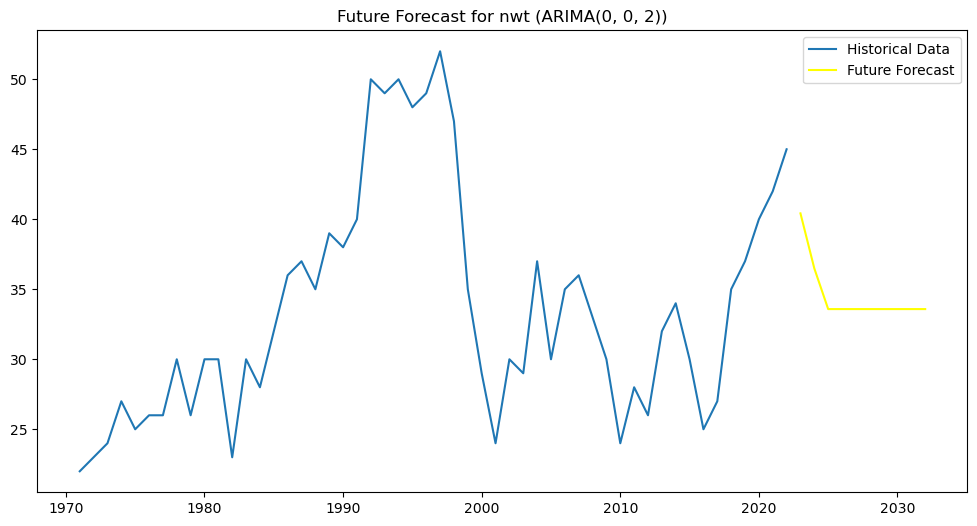

Best ARIMA model for ont: ARIMA(1, 2, 2) RMSE=621.45062287329


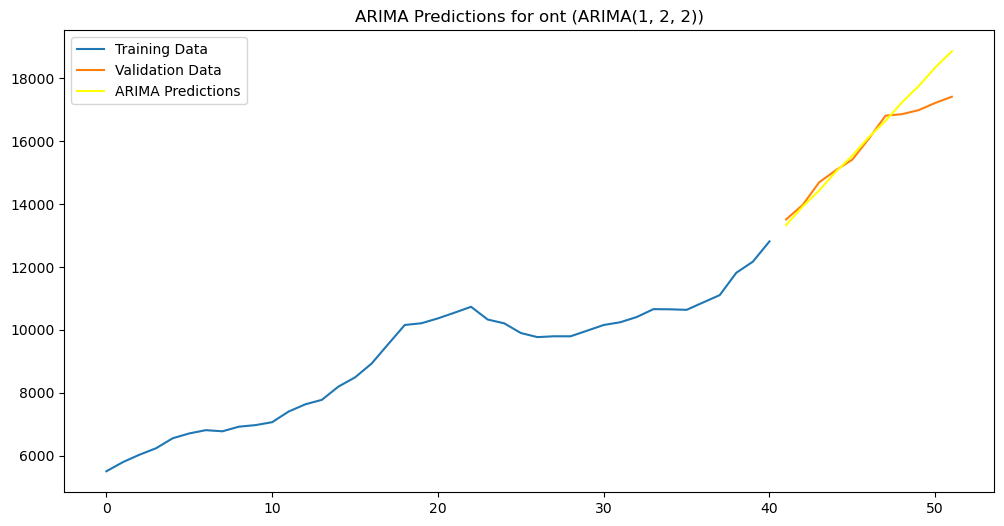

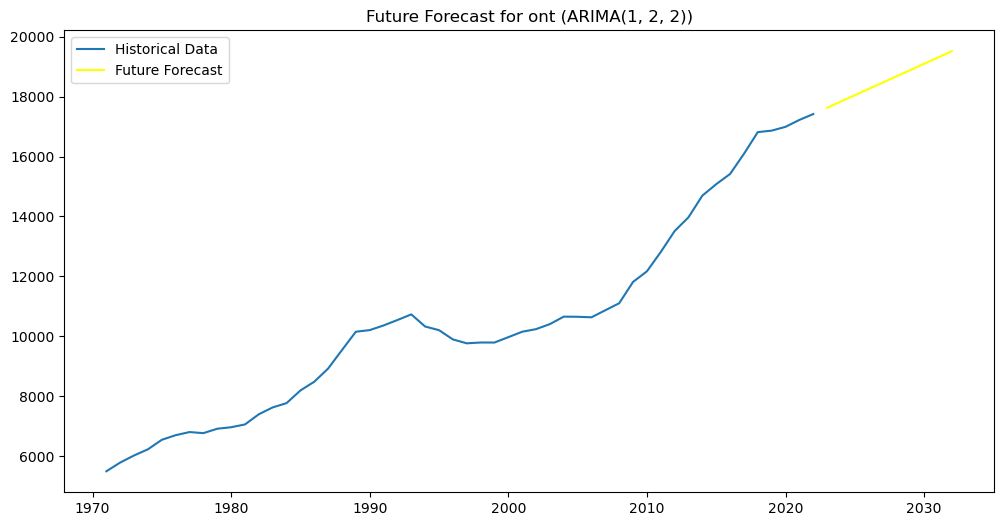

Best ARIMA model for pei: ARIMA(0, 2, 2) RMSE=13.884844989677397


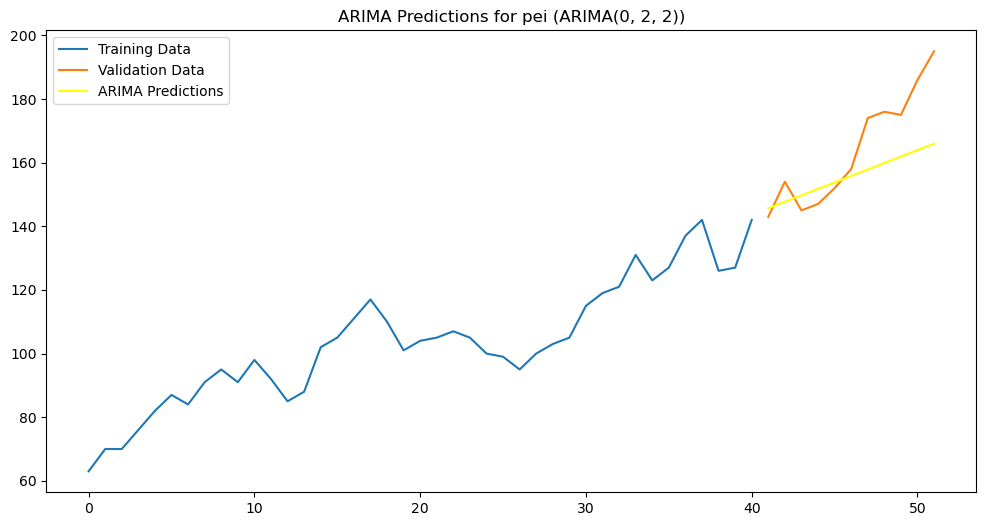

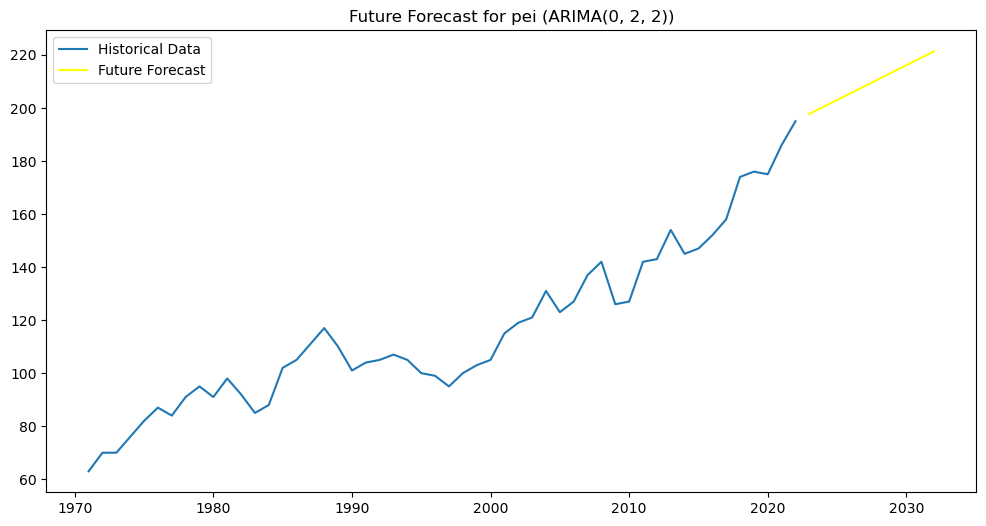

Best ARIMA model for que: ARIMA(1, 2, 0) RMSE=351.8651314240781


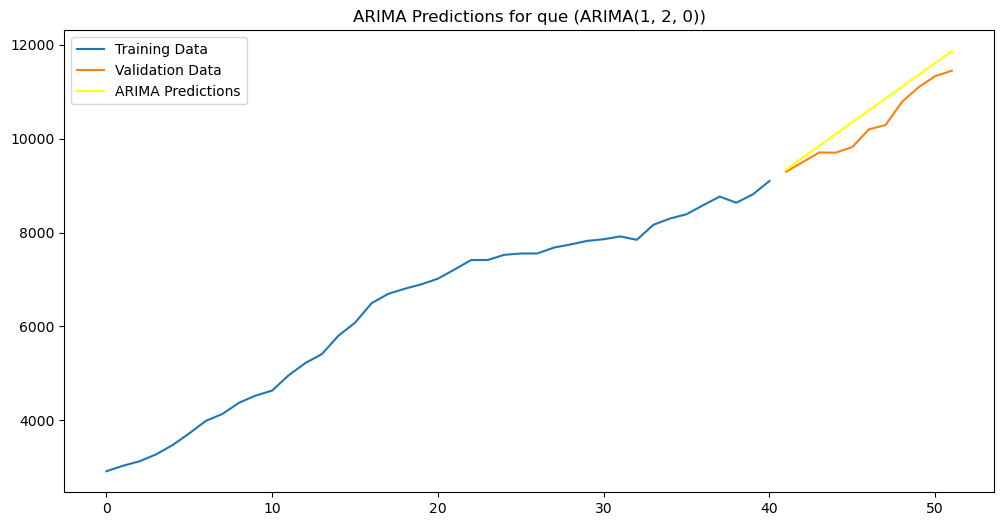

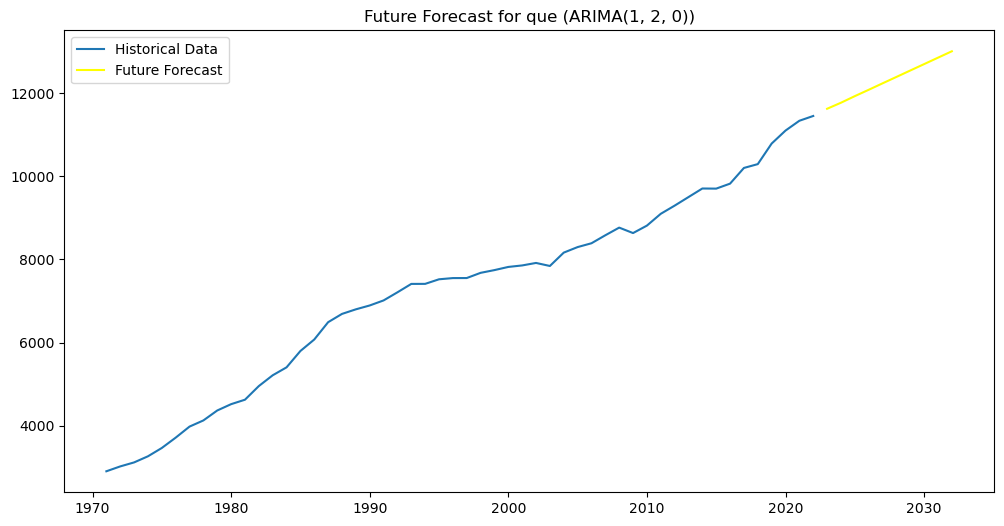

Best ARIMA model for sask: ARIMA(0, 2, 1) RMSE=73.75198732514221


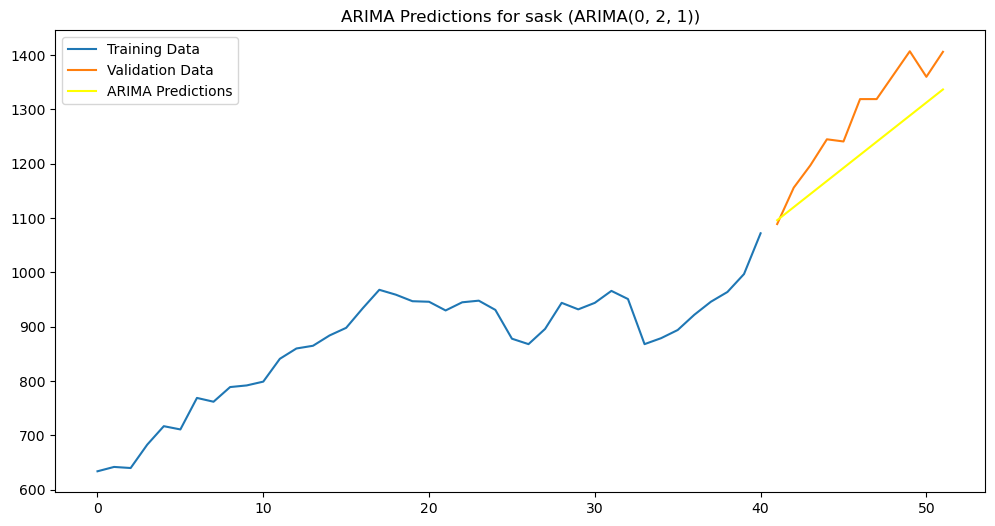

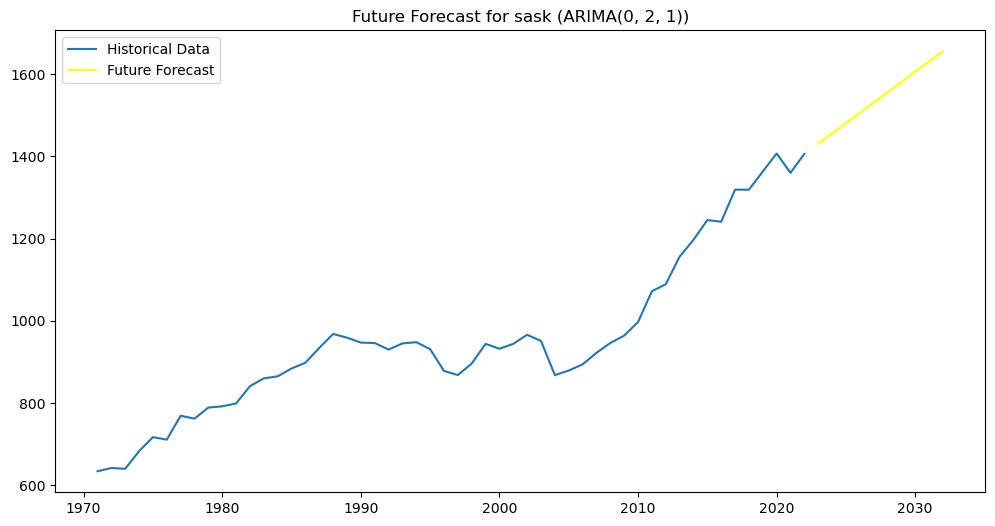

Best ARIMA model for yt: ARIMA(2, 2, 1) RMSE=2.8500608228991284


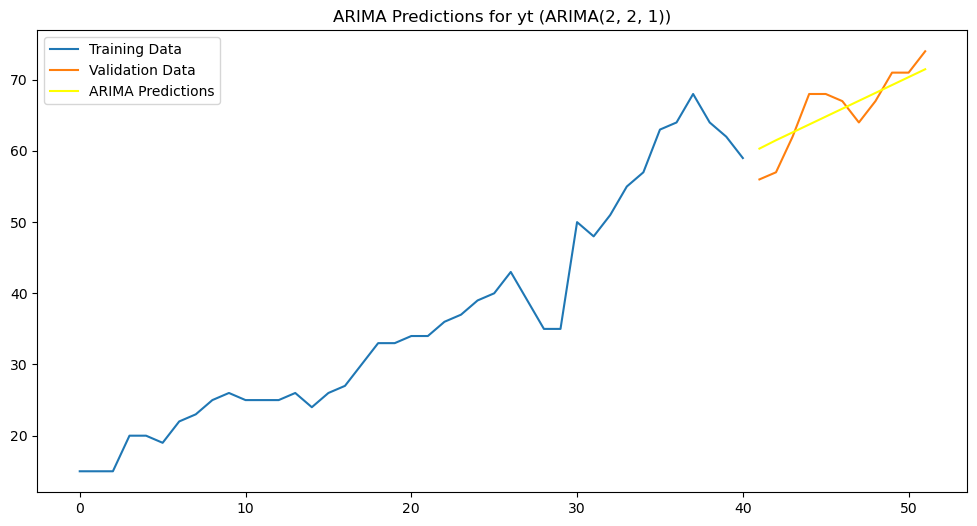

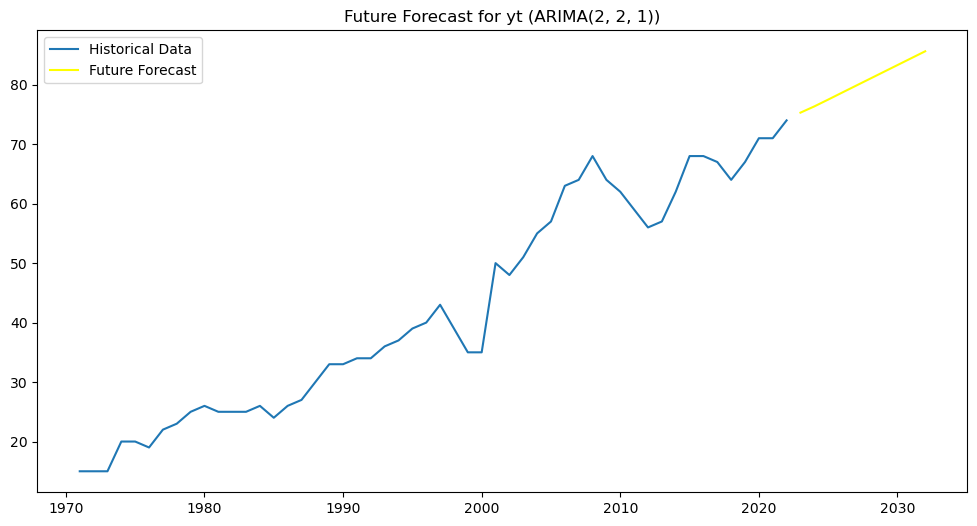

Best ARIMA model for nun: ARIMA(1, 0, 2) RMSE=9.738591823198291


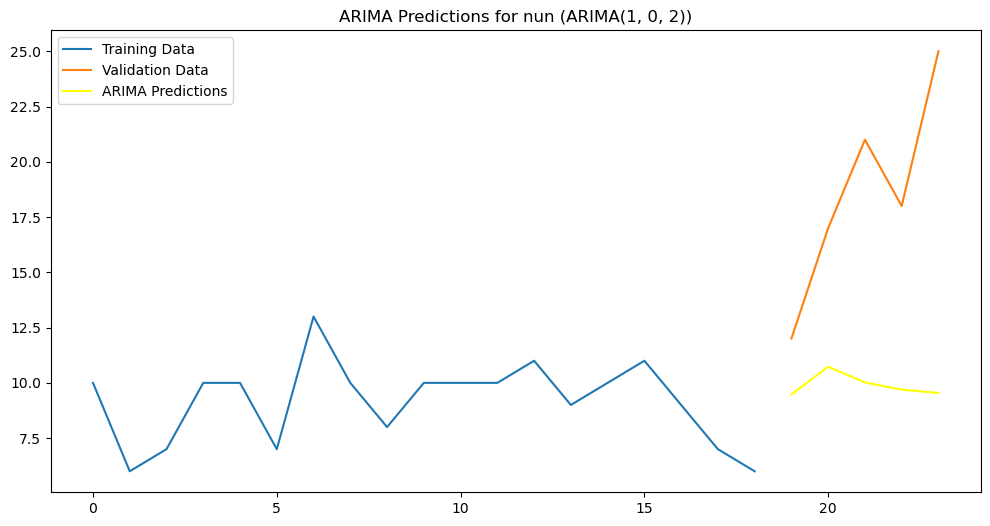

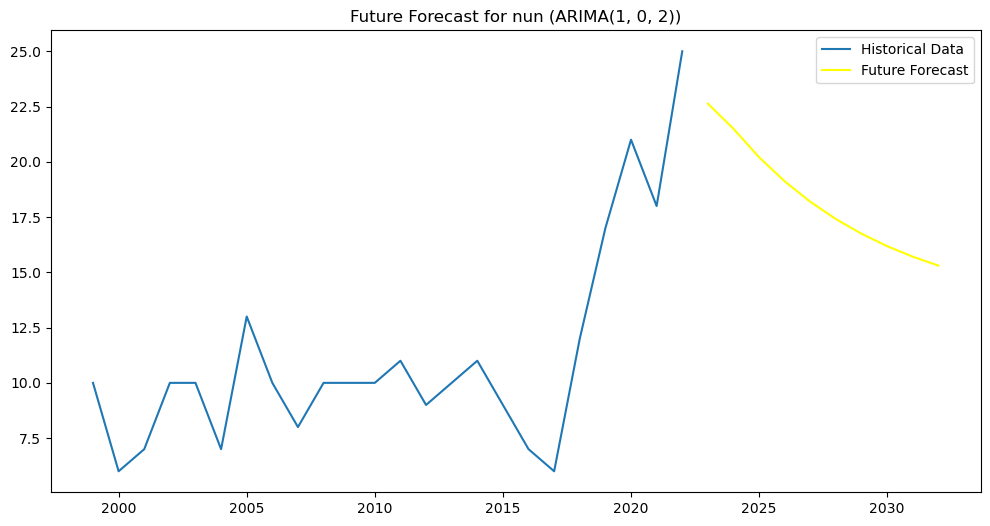

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to evaluate ARIMA model
def evaluate_arima_model(train, validation, arima_order):
    try:
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        y_pred = model_fit.get_forecast(steps=len(validation))
        y_pred_df = y_pred.conf_int(alpha=0.05)
        y_pred_df["Predictions"] = model_fit.predict(start=validation.index[0], end=validation.index[-1])
        y_pred_df.index = validation.index
        y_pred_out = y_pred_df["Predictions"]
        rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
        return rmse, model_fit, y_pred_df
    except Exception as e:
        print(f"Failed to fit ARIMA{arima_order}: {str(e)}")
        return float('inf'), None, None  # Return infinite RMSE if model fails to converge

# Loop through each jurisdiction and prepare data for ARIMA
for jurisdiction, df in jurisdiction_dfs.items():
    try:
        # Extract 'Year' and 'Number of physicians' columns and sort by 'Year'
        jurisdiction_data = df[['Year', 'Number of physicians']].sort_values(by='Year').reset_index(drop=True)
        
        # Split data into train and validation sets
        train_size = int(len(jurisdiction_data) * 0.8)
        train, validation = jurisdiction_data['Number of physicians'][:train_size], jurisdiction_data['Number of physicians'][train_size:]
        
        # Use the best ARIMA model parameters for the jurisdiction
        arima_order = best_models[jurisdiction][0]  # Assuming best_models contains the best (p, d, q) for each jurisdiction
        
        # Evaluate the best ARIMA model on the validation set
        rmse, model_fit, y_pred_df = evaluate_arima_model(train, validation, arima_order)
        
        # Print the best ARIMA model results for each jurisdiction
        print(f'Best ARIMA model for {jurisdiction}: ARIMA{arima_order} RMSE={rmse}')
        
        if model_fit is None:
            print(f'Failed to find a suitable ARIMA model for {jurisdiction}')
            continue
        
        # Plotting for the best ARIMA model
        if model_fit is not None:
            # Make predictions on the validation set
            y_pred_out = y_pred_df["Predictions"]
            
            # Plotting
            plt.figure(figsize=(12, 6))
            plt.plot(train, label='Training Data')
            plt.plot(validation, label='Validation Data')
            plt.plot(y_pred_out, color='yellow', label='ARIMA Predictions')
            plt.title(f'ARIMA Predictions for {jurisdiction} (ARIMA{arima_order})')
            plt.legend()
            plt.show()
            
            # If satisfied with the model, fit it on the entire dataset
            ARIMAmodel_full = ARIMA(jurisdiction_data['Number of physicians'], order=arima_order)
            ARIMAmodel_full = ARIMAmodel_full.fit()
            
            # Forecast future values (10 years)
            forecast_steps = 10  # Number of future periods to forecast
            future_forecast = ARIMAmodel_full.get_forecast(steps=forecast_steps)
            future_forecast_df = future_forecast.conf_int(alpha=0.05)
            future_forecast_df["Predictions"] = ARIMAmodel_full.predict(start=len(jurisdiction_data), end=len(jurisdiction_data) + forecast_steps - 1)
            
            plt.figure(figsize=(12, 6))
            plt.plot(jurisdiction_data['Year'], jurisdiction_data['Number of physicians'], label='Historical Data')
            future_years = range(jurisdiction_data['Year'].max() + 1, jurisdiction_data['Year'].max() + forecast_steps + 1)  # Add 1 to include all forecast years
            plt.plot(future_years, future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
            plt.title(f'Future Forecast for {jurisdiction} (ARIMA{arima_order})')
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Error processing jurisdiction {jurisdiction}: {str(e)}")
        continue
